In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
import pandas as pd
import numpy as np

# 1. 데이터 로드 (이전 단계에서 생성한 파일)
data_path = '생성자료/enhanced_churn_data_100k.csv'
df = pd.read_csv(data_path)

# 2. 파생변수 생성 (Feature Engineering)
# "최근 3개월간 사용 실적이 없거나 낮으면 이탈"이라는 현직자 룰을 데이터에 반영
df['recent_3m_sum'] = df['spent_m1'] + df['spent_m2'] + df['spent_m3']

df

,customer_id,age,gender,region,tenure_months,income_band,card_grade,contract_cancelled,complaints_6m,marketing_open_rate_6m,...,txn_m1,login_m1,total_spent_6m,total_txn_6m,total_login_6m,points_balance,revolving_usage,cash_service_usage,churn,recent_3m_sum
0,1,47,M,Chungcheong,17,low,Silver,0,2,0.610,...,9,13,3626727,74,96,38845,0,0,0,1797011
1,2,40,F,Gyeonggi,71,low,Silver,0,0,0.688,...,15,19,3297593,64,101,35958,0,0,0,1789278
2,3,49,M,Gyeonggi,83,very_high,Diamond,0,1,0.674,...,188,12,38383710,886,91,384306,0,0,0,17761555
3,4,60,F,Daegu,38,mid,Silver,0,1,0.454,...,25,6,10158064,183,74,104595,0,0,0,5095434
4,5,39,M,Gyeonggi,108,very_high,Diamond,0,0,0.789,...,120,15,30575403,652,83,310462,0,0,0,15123943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,39,M,Jeolla,21,low,Silver,0,1,0.736,...,8,12,2713756,51,85,32063,0,0,0,1284324
99996,99997,35,F,Gyeonggi,65,low,Gold,0,0,0.597,...,8,15,2605609,52,90,30211,0,0,0,1303180
99997,99998,46,F,Daegu,33,mid,Platinum,0,1,0.559,...,37,16,7722282,161,93,77733,0,0,0,3723377
99998,99999,39,F,Gwangju,82,low,Silver,0,2,0.619,...,9,16,2711194,61,76,28533,0,0,0,1369874


In [3]:
# 3. 불필요한 컬럼 제거 (Feature Selection)
# customer_id: 단순 식별자
# contract_cancelled: 정답지(Target)가 유출되는 변수이므로 삭제 (Data Leakage 방지)
df_clean = df.drop(['customer_id', 'contract_cancelled'], axis=1)

# 4. One-Hot Encoding (문자열 -> 숫자 변환)
# 범주형 변수(성별, 지역 등)를 모델이 이해할 수 있게 0과 1로 펼쳐줍니다.
df_final = pd.get_dummies(df_clean)

# 5. X, y 데이터 분리
X = df_final.drop('churn', axis=1)  # 정답 컬럼 제외한 모든 변수
y = df_final['churn']               # 정답 컬럼

print("전처리 완료!")
print(f"X 데이터 크기: {X.shape}")  # (100000, 53) 예상
print(f"y 데이터 크기: {y.shape}")  # (100000,) 예상

# 확인용 출력
print("\n[X 데이터 컬럼 목록]")
print(X.columns.tolist()[:10], "... 등 총 53개")

전처리 완료!
X 데이터 크기: (100000, 53)
y 데이터 크기: (100000,)

[X 데이터 컬럼 목록]
['age', 'tenure_months', 'complaints_6m', 'marketing_open_rate_6m', 'spent_m6', 'txn_m6', 'login_m6', 'spent_m5', 'txn_m5', 'login_m5'] ... 등 총 53개


In [10]:
# 데이터 분리

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    random_state=42,
    # eval_metric='logloss' # 최신 버전에서는 자동으로 설정되므로 주석 처리
)

xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [12]:
# 8. 예측 및 평가
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("\n[XGBoost 기본 모델 Baseline 평가 결과]")
print(f"ROC-AUC 점수: {roc_auc_score(y_test, y_proba):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report (기본 임계값 0.5):\n", classification_report(y_test, y_pred))


[XGBoost 기본 모델 Baseline 평가 결과]
ROC-AUC 점수: 0.8892
Confusion Matrix:
 [[19438    56]
 [  483    23]]

Classification Report (기본 임계값 0.5):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     19494
           1       0.29      0.05      0.08       506

    accuracy                           0.97     20000
   macro avg       0.63      0.52      0.53     20000
weighted avg       0.96      0.97      0.96     20000



In [13]:
# 3. 불균형 가중치 계산 (scale_pos_weight 설정용)
# 비율 = (Non-churners 수) / (Churners 수)
non_churn_count = (y_train == 0).sum()
churn_count = (y_train == 1).sum()
scale_pos_weight_value = non_churn_count / churn_count
print(f"계산된 scale_pos_weight: {scale_pos_weight_value:.2f}") 
# 이 값(약 39~40)을 이탈 클래스에 대한 가중치로 고정하여 Recall을 높입니다.

계산된 scale_pos_weight: 38.49


In [15]:
from scipy.stats import uniform, randint

In [19]:
user_params = {
    'objective' : 'binary:logistic',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_child_weight': 3,
    'gamma': 0.1,
    'scale_pos_weight': scale_pos_weight_value, # 계산된 값 적용
    'random_state': 42
}

print("\nXGBoost 모델 학습 중...")
xgb_model = XGBClassifier(**user_params)
xgb_model.fit(X_train, y_train)

# 6. 예측 및 평가



XGBoost 모델 학습 중...


In [21]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

y_pred

array([0, 1, 1, ..., 0, 0, 0], shape=(20000,))

In [22]:
y_proba

array([1.4997019e-04, 5.6090659e-01, 6.0673755e-01, ..., 9.4466042e-05,
       4.1439852e-01, 3.5783846e-04], shape=(20000,), dtype=float32)

In [23]:
print("\n[XGBoost 사용자 지정 모델 평가 결과]")
print(f"ROC-AUC 점수: {roc_auc_score(y_test, y_proba):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report (기본 임계값 0.5):\n", classification_report(y_test, y_pred))


[XGBoost 사용자 지정 모델 평가 결과]
ROC-AUC 점수: 0.8960
Confusion Matrix:
 [[16673  2821]
 [  138   368]]

Classification Report (기본 임계값 0.5):
               precision    recall  f1-score   support

           0       0.99      0.86      0.92     19494
           1       0.12      0.73      0.20       506

    accuracy                           0.85     20000
   macro avg       0.55      0.79      0.56     20000
weighted avg       0.97      0.85      0.90     20000



In [24]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0,6, 0.7, 0.8, 0.9]
for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    print(f"\n=== Threshold: {threshold} ===")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


=== Threshold: 0.1 ===
[[12948  6546]
 [   15   491]]
              precision    recall  f1-score   support

           0       1.00      0.66      0.80     19494
           1       0.07      0.97      0.13       506

    accuracy                           0.67     20000
   macro avg       0.53      0.82      0.46     20000
weighted avg       0.98      0.67      0.78     20000


=== Threshold: 0.2 ===
[[13952  5542]
 [   38   468]]
              precision    recall  f1-score   support

           0       1.00      0.72      0.83     19494
           1       0.08      0.92      0.14       506

    accuracy                           0.72     20000
   macro avg       0.54      0.82      0.49     20000
weighted avg       0.97      0.72      0.82     20000


=== Threshold: 0.3 ===
[[14804  4690]
 [   62   444]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     19494
           1       0.09      0.88      0.16       506

    accuracy     

C:\Users\Admin\miniconda3\envs\eda_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Admin\miniconda3\envs\eda_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Admin\miniconda3\envs\eda_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

In [28]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

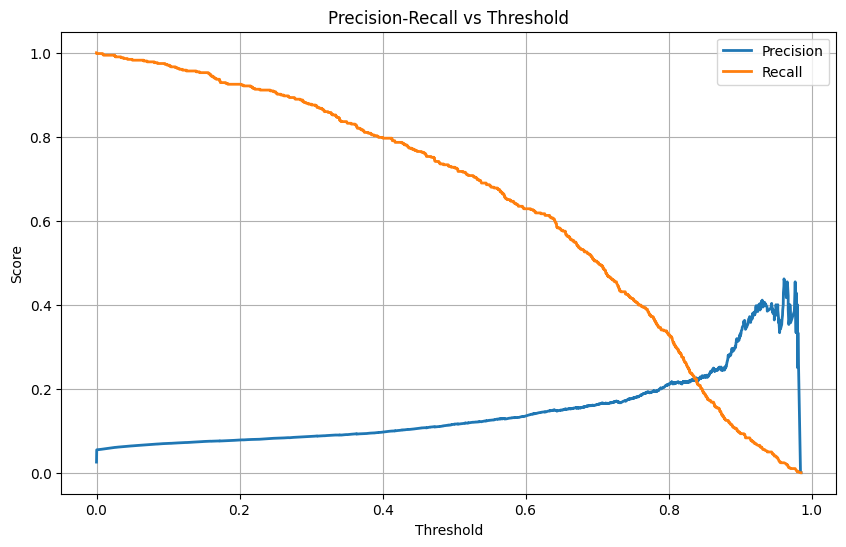

Optimal Threshold (F1 maximized): 0.804
Precision: 0.216
Recall: 0.324
F1-Score: 0.259


In [29]:
# Precision-Recall curve 계산
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
plt.plot(thresholds, recall[:-1], label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision-Recall vs Threshold')
plt.grid(True)
plt.show()

# F1-Score가 최대인 threshold 찾기
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (F1 maximized): {optimal_threshold:.3f}")
print(f"Precision: {precision[optimal_idx]:.3f}")
print(f"Recall: {recall[optimal_idx]:.3f}")
print(f"F1-Score: {f1_scores[optimal_idx]:.3f}")

In [34]:
import lightgbm as lgb

In [36]:
lgbm_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_child_weight': 3,          # XGBoost의 min_child_weight와 동일하게 사용
    'min_gain_to_split': 0.1,       # XGBoost의 gamma(최소 손실 감소)에 대응
    'scale_pos_weight': scale_pos_weight_value, # 계산된 값 적용
    'random_state': 42
}

In [37]:
lgb_model = lgb.LGBMClassifier(**lgbm_params)
lgb_model.fit(X_train, y_train)


[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Info] Number of positive: 2026, number of negative: 77974
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4892
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025325 -> initscore=-3.650312
[LightGBM] [Info] Start training from score -3.650312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,3
,min_child_samples,20


In [39]:
# 예측 및 평가
y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1


In [40]:
print("\n[LightGBM 사용자 지정 모델 평가 결과]")
print(f"ROC-AUC 점수: {roc_auc_score(y_test, y_proba):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report (기본 임계값 0.5):\n", classification_report(y_test, y_pred))


[LightGBM 사용자 지정 모델 평가 결과]
ROC-AUC 점수: 0.8919
Confusion Matrix:
 [[16733  2761]
 [  150   356]]

Classification Report (기본 임계값 0.5):
               precision    recall  f1-score   support

           0       0.99      0.86      0.92     19494
           1       0.11      0.70      0.20       506

    accuracy                           0.85     20000
   macro avg       0.55      0.78      0.56     20000
weighted avg       0.97      0.85      0.90     20000



In [ ]:
[XGBoost 사용자 지정 모델 평가 결과]
ROC-AUC 점수: 0.8960
Confusion Matrix:
 [[16673  2821]
 [  138   368]]

Classification Report (기본 임계값 0.5):
               precision    recall  f1-score   support

           0       0.99      0.86      0.92     19494
           1       0.12      0.73      0.20       506

    accuracy                           0.85     20000
   macro avg       0.55      0.79      0.56     20000
weighted avg       0.97      0.85      0.90     20000

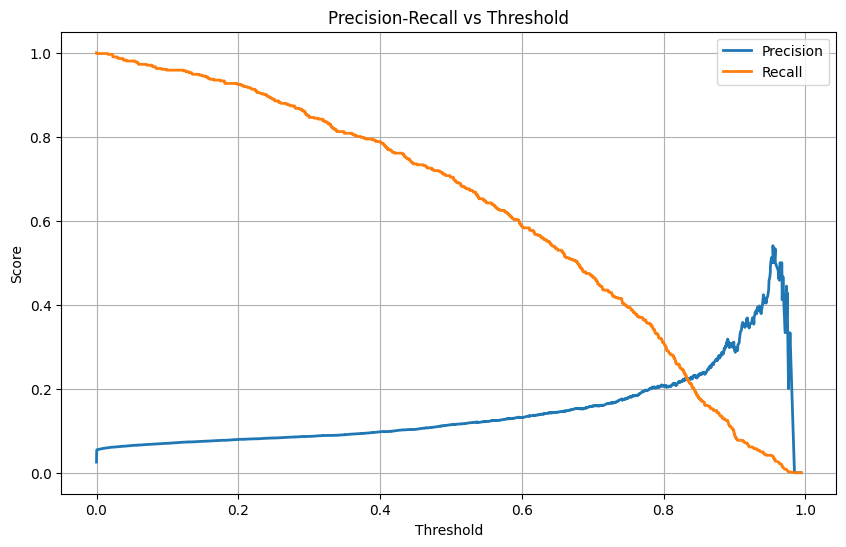

Optimal Threshold (F1 maximized): 0.785
Precision: 0.204
Recall: 0.348
F1-Score: 0.257


In [41]:
# Precision-Recall curve 계산
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
plt.plot(thresholds, recall[:-1], label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision-Recall vs Threshold')
plt.grid(True)
plt.show()

# F1-Score가 최대인 threshold 찾기
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (F1 maximized): {optimal_threshold:.3f}")
print(f"Precision: {precision[optimal_idx]:.3f}")
print(f"Recall: {recall[optimal_idx]:.3f}")
print(f"F1-Score: {f1_scores[optimal_idx]:.3f}")